In [26]:
import jax 
import jax.numpy as jnp
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import optax
from tqdm import tqdm

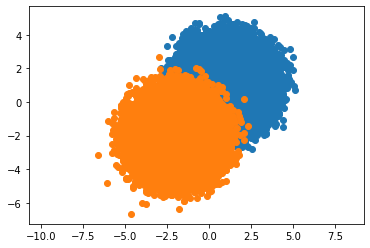

In [28]:
# Distribution 1
def dist_1(rng_key, nb_samples, nb_epoch):
    return jax.random.multivariate_normal(rng_key, 
                                          mean=jnp.array([1,1]), 
                                          cov=jnp.eye(2),
                                          shape=[nb_epoch, nb_samples,])


# Distribution 2
def dist_2(rng_key, nb_samples, nb_epoch):
    return jax.random.multivariate_normal(rng_key, 
                                          mean=jnp.array([-2,-2]), 
                                          cov=jnp.eye(2),
                                          shape=[nb_epoch, nb_samples,])
# Sample from each distribution
nb_samples = 100000
rng_key = jax.random.PRNGKey(42)
x_key, y_key = jax.random.split(rng_key)
x = dist_1(x_key, nb_samples, 1)[0]
y = dist_2(y_key, nb_samples, 1)[0]

plt.plot(x[:,0], x[:, 1], 'o')
plt.plot(y[:,0], y[:, 1], 'o')
plt.axis('equal');

In [29]:
def descriminator(x):
    mlp = hk.nets.MLP([128, 128, 1])
    return mlp(x)


descriminator = hk.transform(descriminator)
descriminator = hk.without_apply_rng(descriminator)

# Generation des données
nb_samples = 64
nb_epoch = 5000
rng_key = jax.random.PRNGKey(42)

params_key, x_key, y_key = jax.random.split(rng_key, 3)
all_x = dist_1(x_key, nb_samples, nb_epoch)
all_y = dist_2(y_key, nb_samples, nb_epoch)

# Initalisation du modèle
params_init = descriminator.init(params_key, all_x[0])

# Weight Clipping

In [15]:
def weight_clipping(params, x, y):
    f_x = descriminator.apply(params, x)
    f_y = descriminator.apply(params, y)
    
    return jnp.mean(f_x - f_y)

# Loss et gradient
value_loss = jax.value_and_grad(weight_clipping)

c = 0.01
@jax.jit
def step(params, opt_state, x, y):
    loss, gradient = value_loss(params, x, y)
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    
    # Minus before updates as we want gradient ascent 
    params = optax.apply_updates(params, jax.tree_map(lambda x: -x, updates))
    params = jax.tree_map(lambda x: jnp.clip(x, -c, c), params)
    
    return params, opt_state, loss

# Training
optimizer = optax.rmsprop(5e-5)
opt_state = optimizer.init(params_init)
params = params_init.copy()


loss_list = []
for i in tqdm(range(nb_epoch)):
    x, y = all_x[i], all_y[i]
    
    params, opt_state, loss = step(params, opt_state, x, y)
    if i % 10 == 0:
        loss_list.append(loss)

100%|██████████████████████████████████████| 5000/5000 [00:10<00:00, 486.63it/s]


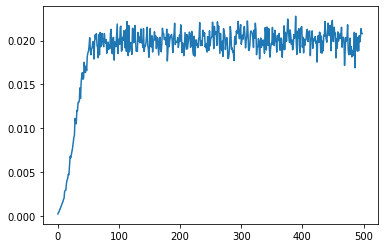

In [16]:
plt.plot(loss_list[1:]);

# Gradient Penalisation

In [53]:
def descriminator_fn(params, x):
    return descriminator.apply(params, x)[0]

desc_grad = jax.grad(descriminator_fn, argnums=1)
desc_grad_batch = jax.vmap(desc_grad, in_axes=(None, 0))

def gradient_penality(params, lmb, x, y, z):
    f_x = descriminator.apply(params, x)
    f_y = descriminator.apply(params, y)

    grad_z = desc_grad_batch(params_init, z)
    grad_pen = jnp.mean(jnp.square(1 - jnp.linalg.norm(grad_z, axis=1)))

    return jnp.mean(f_x - f_y) - lmb*grad_pen

# Loss et gradient
value_loss = jax.value_and_grad(gradient_penality)

# Sampling the z points
nb_z_sample = 1000

def dist_z(rnd_key, x_batch, y_batch):
    x_sample_key, y_sample_key, alpha_key = jax.random.split(rng_key, 3)

    x_sample = jax.random.choice(x_sample_key, x_batch, [nb_z_sample,])
    y_sample = jax.random.choice(y_sample_key, y_batch, [nb_z_sample,])

    alpha_sample = jax.random.uniform(alpha_key, shape=[nb_z_sample,1])
    return alpha_sample * x_sample + (1 - alpha_sample) * y_sample

all_dist_z = jax.vmap(dist_z, in_axes=(0, 0, 0))

rng_sample = jax.random.split(x_key, nb_epoch)
all_z = all_dist_z(rng_sample, all_x, all_y)

@jax.jit
def step(params, opt_state, lmb, x, y, z):
    loss, gradient = value_loss(params, lmb, x, y, z)
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    
    # Minus before updates as we want gradient ascent 
    params = optax.apply_updates(params, jax.tree_map(lambda x: -x, updates))

    return params, opt_state, loss


# Training
optimizer = optax.adam(1e-4, b1=0, b2=0.9)
opt_state = optimizer.init(params_init)
params = params_init.copy()

loss_list = []
lmb = 10
for i in range(nb_epoch):
    x, y, z = all_x[i], all_y[i], all_z[i]
    
    params, opt_state, loss = step(params, opt_state, lmb, x, y, z)
    if i % 100 == 0:
        grad_z = desc_grad_batch(params_init, z)
        grad_pen = jnp.mean(jnp.square(1 - jnp.linalg.norm(grad_z, axis=1)))
        print(grad_pen)
        loss_list.append(loss)

0.6125352
0.61173624
0.61989784
0.6158708
0.59730804
0.61857605
0.64318764
0.6105381
0.63576007
0.6341129
0.6203199
0.66175574
0.6200847
0.6051298
0.6421933
0.6254994
0.59821135
0.61607665
0.63091666
0.6249795
0.6334683
0.60651076
0.63292766
0.6094427
0.6401076
0.61544204
0.6124556
0.63244015
0.6433189
0.61822
0.60707116
0.634412
0.61464715
0.62887883
0.6148896
0.62726945
0.63160634
0.6237062
0.63292474
0.61570334
0.6074846
0.6242114
0.62217
0.6468887
0.62212956
0.62184244
0.61569
0.6253749
0.6348482
0.62658626


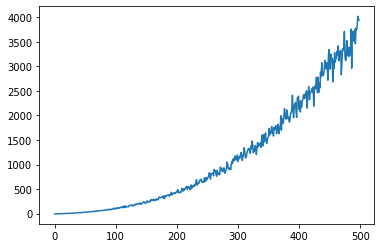

In [47]:
plt.plot(loss_list[1:]);

In [216]:
rng = jax.random.PRNGKey(35)
x_sample_key, y_sample_key, alpha_key = jax.random.split(rng, 3)

In [246]:
nb_z_sample = 10

def dist_z(rnd_key, x_batch, y_batch):
    x_sample_key, y_sample_key, alpha_key = jax.random.split(rng_key, 3)

    x_sample = jax.random.choice(x_sample_key, x_batch, [nb_z_sample,])
    y_sample = jax.random.choice(y_sample_key, y_batch, [nb_z_sample,])

    alpha_sample = jax.random.uniform(alpha_key, shape=[nb_z_sample,1])
    return alpha_sample * x_sample + (1 - alpha_sample) * y_sample

all_dist_z = jax.vmap(dist_z, in_axes=(0, 0, 0))

In [247]:
rng_sample = jax.random.split(rng, nb_epoch)

z_sample = all_dist_z(rng_sample, all_x, all_y)

In [248]:
z_sample.shape

(500, 10, 2)

In [209]:
a = x_sample[0][1] - y_sample[0][1] / x_sample[0][0] - y_sample[0][0]
b = x_sample[0][1] - a*x_sample[0][0]

In [ ]:
    alpha = tf.random_uniform(
        shape=[BATCH_SIZE,1], 
        minval=0.,
        maxval=1.
    )
    interpolates = alpha*real_data + ((1-alpha)*fake_data)

In [223]:
alpha_sample.reshape(-1, 1) * x_sample

DeviceArray([[ 0.09826772,  0.28130066],
             [-0.1171492 ,  0.35154867],
             [ 0.5872353 ,  0.4218715 ],
             [-0.0857889 , -0.01647572],
             [ 0.34316218,  0.935491  ],
             [ 0.37201458,  0.28533238],
             [ 0.2625964 ,  0.20140946],
             [-0.3533344 ,  0.967182  ],
             [ 0.521218  ,  1.5668927 ],
             [ 0.0653855 ,  0.1962146 ]], dtype=float32)

In [220]:
x_sample

DeviceArray([[ 0.10448319,  0.299093  ],
             [-0.6193963 ,  1.8587234 ],
             [ 2.0671473 ,  1.4850446 ],
             [-0.5834571 , -0.11205268],
             [ 0.4230168 ,  1.1531819 ],
             [ 0.57705307,  0.44259536],
             [ 0.57705307,  0.44259536],
             [-0.43467617,  1.1898388 ],
             [ 0.8885118 ,  2.6710563 ],
             [ 0.22291094,  0.6689309 ]], dtype=float32)

# $c$-transform

In [30]:
def cost_fn(x, y):
    return jnp.sqrt(jnp.sum(jnp.square(x - y)))


def c_transform(params, x, y):
    # Get the cost (by default d_2) for one y with every x
    cost_fn_all_x = jax.vmap(cost_fn, in_axes=(0, None))

    # Get the cost (by default d_2) for every y with every x
    cost_matrix = jax.vmap(cost_fn_all_x, in_axes=(None, 0))

    # Get the matrix define in (20)
    A = cost_matrix(x, y) - descriminator.apply(params, x).T 
    
    # C-transform
    min_A = jnp.min(A, axis=1)
    
    return jnp.mean(descriminator.apply(params, x) + min_A)


value_loss = jax.value_and_grad(c_transform)

@jax.jit
def step(params, opt_state, x, y):
    loss, gradient = value_loss(params, x, y)
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    
    # Minus before updates as we want gradient ascent 
    params = optax.apply_updates(params, jax.tree_map(lambda x: -x, updates))
    params = jax.tree_map(lambda x: jnp.clip(x, -c, c), params)
    
    return params, opt_state, loss

# Training
optimizer = optax.rmsprop(1e-4)
opt_state = optimizer.init(params_init)
params = params_init.copy()


loss_list = []
for i in tqdm(range(nb_epoch)):
    x, y = all_x[i], all_y[i]
    
    params, opt_state, loss = step(params, opt_state, x, y)
    if i % 10 == 0:
        loss_list.append(loss)

100%|██████████████████████████████████████| 5000/5000 [00:11<00:00, 450.61it/s]


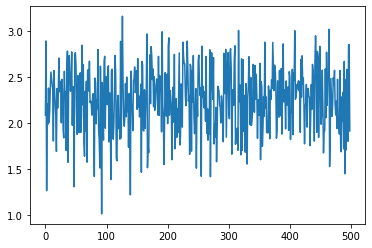

In [31]:
plt.plot(loss_list[1:]);

# ($c$, $\epsilon$)-transform

In [27]:
def c_eps_transform(params, all_x, eps, x, y):
    f_x = descriminator.apply(params, x)
    
    cost_fn_all_x = jax.vmap(cost_fn, in_axes=(1, None))
    descriminator_all_x = jax.vmap(descriminator, in_axes=(None, 1))
    A = cost_fn_all_x(all_x, y) - descriminator_all_x(params, all_x)
    f_y = -eps*jnp.log(jnp.mean(jnp.exp(A/eps)))
    
    return f_x - f_y